In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import jit

In [3]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [4]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [6]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [7]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [8]:
stdampall_ad = np.load('../features/stdampall_ad.npy')
stdampq2_ad = np.load('../features/stdampq2_ad.npy')
stdampq3_ad = np.load('../features/stdampq3_ad.npy')
stdampq4_ad = np.load('../features/stdampq4_ad.npy')

meanampall_ad = np.load('../features/meanampall_ad.npy')
meanampq2_ad = np.load('../features/meanampq2_ad.npy')
meanampq3_ad = np.load('../features/meanampq3_ad.npy')
meanampq4_ad = np.load('../features/meanampq4_ad.npy')

meanamppos = np.load('../features/meanamppos.npy')
meanampneg = np.load('../features/meanampneg.npy')


In [9]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg})

In [10]:
train_features['CoVar_AD'] = train_features['StdAmpAll_AD']/train_features['MeanAmpAll_AD']

In [11]:
train = pd.concat([meta_train, train_features], axis=1)

In [12]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg,CoVar_AD
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428,44.891664,0.670594,85.296720,24.976989,4.062346,0.000151,14.999402,1.249880,11.181670,-10.294509,11.050675
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461,30.568193,35.273220,43.143698,24.977523,1.875258,2.500917,3.750465,1.249668,8.331531,-8.799846,16.300790
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683,30.570660,43.144629,35.274377,24.978110,1.875325,3.750685,2.500106,1.250578,9.514662,-10.973763,16.301528
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391,87.000132,60.780813,70.004487,43.144785,15.624495,7.500015,9.998660,3.750652,8.910585,-6.666027,5.568188
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139,84.430994,60.780715,65.567084,24.979410,14.686710,7.499892,8.748330,1.249292,3.898276,-3.984866,5.748802


In [13]:
signal_id = train['signal_id'].values
del train['signal_id']

In [14]:
target = train['target'].values
del train['target']

In [15]:
from sklearn.metrics import matthews_corrcoef

In [16]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)

[1]	valid_0's MCC: 0.575588
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.607887
[3]	valid_0's MCC: 0.598426
[4]	valid_0's MCC: 0.60284
[5]	valid_0's MCC: 0.611931
[6]	valid_0's MCC: 0.611457
[7]	valid_0's MCC: 0.610269
[8]	valid_0's MCC: 0.616622
[9]	valid_0's MCC: 0.614733
[10]	valid_0's MCC: 0.616831
[11]	valid_0's MCC: 0.615179
[12]	valid_0's MCC: 0.617723
[13]	valid_0's MCC: 0.617366
[14]	valid_0's MCC: 0.615179
[15]	valid_0's MCC: 0.616831
[16]	valid_0's MCC: 0.620043
[17]	valid_0's MCC: 0.62631
[18]	valid_0's MCC: 0.624044
[19]	valid_0's MCC: 0.625247
[20]	valid_0's MCC: 0.625749
[21]	valid_0's MCC: 0.619577
[22]	valid_0's MCC: 0.621992
[23]	valid_0's MCC: 0.621992
[24]	valid_0's MCC: 0.620043
[25]	valid_0's MCC: 0.629043
[26]	valid_0's MCC: 0.629043
[27]	valid_0's MCC: 0.629043
[28]	valid_0's MCC: 0.62634
[29]	valid_0's MCC: 0.629043
[30]	valid_0's MCC: 0.62634
[31]	valid_0's MCC: 0.62634
[32]	valid_0's MCC: 0.627223
[33]	valid_0's MCC: 0.63

[126]	valid_0's MCC: 0.643802
[127]	valid_0's MCC: 0.639925
[128]	valid_0's MCC: 0.644428
[129]	valid_0's MCC: 0.649198
[130]	valid_0's MCC: 0.649198
[131]	valid_0's MCC: 0.646297
Early stopping, best iteration is:
[101]	valid_0's MCC: 0.658311
0.6583110804830289 0.6583110804830289
[1]	valid_0's MCC: 0.534845
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.554134
[3]	valid_0's MCC: 0.57463
[4]	valid_0's MCC: 0.593169
[5]	valid_0's MCC: 0.584756
[6]	valid_0's MCC: 0.581648
[7]	valid_0's MCC: 0.5909
[8]	valid_0's MCC: 0.595115
[9]	valid_0's MCC: 0.596982
[10]	valid_0's MCC: 0.609894
[11]	valid_0's MCC: 0.604597
[12]	valid_0's MCC: 0.605903
[13]	valid_0's MCC: 0.592791
[14]	valid_0's MCC: 0.595115
[15]	valid_0's MCC: 0.595115
[16]	valid_0's MCC: 0.599274
[17]	valid_0's MCC: 0.601624
[18]	valid_0's MCC: 0.606393
[19]	valid_0's MCC: 0.60346
[20]	valid_0's MCC: 0.610542
[21]	valid_0's MCC: 0.610542
[22]	valid_0's MCC: 0.60837
[23]	valid_0's MCC: 0.608813
[2

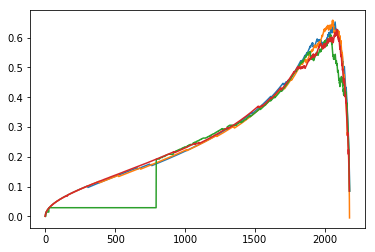

In [17]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in skf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [18]:
proba

[0.42186009128565105,
 0.28834225960471477,
 0.268374954367828,
 0.5034728627473631]

In [19]:
val_mcc

[0.6525050435736901, 0.6583110804830289, 0.6105423008758375, 0.628528783924936]

In [20]:
np.mean(val_mcc)

0.6374718022143732

0.6204985234409182 0.6204985234409182


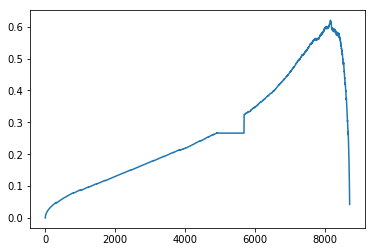

In [21]:
best_proba, best_mcc, y_pred = eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(best_proba)).astype(int))

array([[7983,  204],
       [ 180,  345]])

In [23]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks,2873.879489
MeanAmpAll_AD,1512.159267
NumPosPeaks,794.559733
MeanAmpNeg,635.985468
NumPeaks,542.257260
MinAmp,542.152431
MeanAmpPos,512.275034
MaxAmp,410.498965
id_measurement,337.681680
StdAmpQ2,322.122308


In [24]:
best_proba

0.26976149333352645

In [25]:
comparison = pd.DataFrame({'target':target, 'val_pred':(np.sum(val_pred, axis=1)>np.mean(best_proba)).astype(int)})
train = pd.concat([train, comparison], axis=1)

In [26]:
id_target = train.groupby('id_measurement', as_index=False)['target'].sum()
id_target[id_target['target']==1].count()

id_measurement    19
target            19
dtype: int64

In [27]:
id_target[id_target['target']==2]

,id_measurement,target
67,67,2
601,601,2
608,608,2
620,620,2
706,706,2
944,944,2
988,988,2
1068,1068,2
1076,1076,2
1256,1256,2


In [28]:
train[train['target']==1].loc[:, ['MeanAmpAll_AD', 'MeanAmpNeg', 'NumNegPeaks','target', 'val_pred']].sort_values('NumNegPeaks', ascending=False)

,MeanAmpAll_AD,MeanAmpNeg,NumNegPeaks,target,val_pred
5309,45.936819,-6.469014,702,1,1
5731,82.814297,-25.870692,687,1,1
7467,64.846994,-5.623159,663,1,1
2834,52.186862,-5.036288,642,1,1
5365,82.501508,-25.631389,636,1,1
2343,52.190415,-5.970888,606,1,1
912,53.750484,-7.217735,602,1,1
7469,59.845292,-4.981441,575,1,1
2345,67.501388,-4.866501,569,1,1
4221,63.123945,-7.644917,563,1,1


In [29]:
train.loc[:, ['MeanAmpAll_AD', 'MeanAmpNeg', 'NumNegPeaks','target', 'val_pred']].sort_values('NumNegPeaks', ascending=False).tail(1000)

,MeanAmpAll_AD,MeanAmpNeg,NumNegPeaks,target,val_pred
8219,-5.818640e-05,NaN,0,0,0
184,1.728858e-04,NaN,0,0,0
8198,6.310562e-05,NaN,0,0,0
369,-1.337386e-03,NaN,0,0,0
3661,6.590828e-05,NaN,0,0,0
8210,3.123239e-01,NaN,0,0,0
185,1.210813e-04,NaN,0,0,0
187,1.874839e+00,NaN,0,0,0
4365,-8.193030e-06,NaN,0,0,0
4366,-1.034980e-05,NaN,0,0,0


In [34]:
train[train['target']==1]['id_measurement']

3          1
4          1
5          1
201       67
202       67
228       76
229       76
230       76
270       90
271       90
272       90
279       93
280       93
281       93
285       95
286       95
287       95
290       96
294       98
295       98
296       98
380      126
408      136
409      136
410      136
432      144
433      144
434      144
435      145
436      145
437      145
456      152
457      152
458      152
479      159
516      172
517      172
518      172
570      190
571      190
572      190
678      226
679      226
680      226
699      233
700      233
701      233
705      235
706      235
707      235
708      236
709      236
710      236
813      271
876      292
877      292
878      292
903      301
912      304
913      304
914      304
939      313
940      313
941      313
1002     334
1003     334
1004     334
1017     339
1018     339
1019     339
1026     342
1027     342
1028     342
1032     344
1033     344
1034     344
1050     350